# Checking and cleaning SNP data

Tom Ellis, July 2018

This notebook summarises data inspection and cleaning of SNP data for a sample of 1418 offspring from open-pollinated seed capsules and 2124 adults plants (including maternal plants) from a hybrid zone population of the snapdragon *Antirrhinum majus*. Samples were collected in 2012.

In [1]:
import numpy as np
from faps import *
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Import genotype data for the reproductive adults, and the offspring. The latter includes information on the ID of the maternal mother.

In [2]:
progeny = read_genotypes('../data/offspring_2012_genotypes.csv', mothers_col=1, genotype_col=2)
adults  = read_genotypes('../data/parents_2012_genotypes.csv')

As a sanity check, confirm that the marker names really do match.

In [3]:
all([progeny.markers[i] == adults.markers[i] for i in range(progeny.nloci)])

True

## Missing data

Tissue from the adults and progeny was dried in different ways. For the progeny, I didnt use enough silica gel to dry the tissue rapidly, and the DNA became degraded. Luckily a lot of this is driven by a small number of loci/individuals with very high dropout rates.

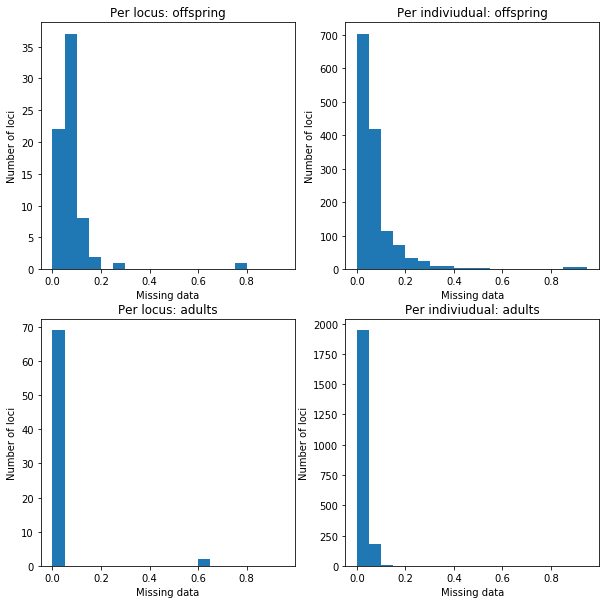

In [4]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.2, hspace=0.2)

mdo = fig.add_subplot(2,2,1)
mdo.hist(progeny.missing_data('marker'), bins=np.arange(0, 1, 0.05))
mdo.set_xlabel("Missing data")
mdo.set_ylabel("Number of loci")
mdo.set_title('Per locus: offspring')

indo = fig.add_subplot(2,2,2)
indo.hist(progeny.missing_data(by='individual'), bins=np.arange(0, 1, 0.05))
indo.set_xlabel("Missing data")
indo.set_ylabel("Number of loci")
indo.set_title('Per indiviudual: offspring')

mda = fig.add_subplot(2,2,3)
mda.hist(adults.missing_data('marker'), bins=np.arange(0, 1, 0.05))
mda.set_xlabel("Missing data")
mda.set_ylabel("Number of loci")
mda.set_title('Per locus: adults')

inda = fig.add_subplot(2,2,4)
inda.hist(adults.missing_data(by='individual'), bins=np.arange(0, 1, 0.05))
inda.set_xlabel("Missing data")
inda.set_ylabel("Number of loci")
inda.set_title('Per indiviudual: adults')
plt.show()

Although overall per locus drop-out rates are low for the adults, there are some individuals with alarmingly high amounts of missing data. Candidates with very few loci typed can come out as being highly compatible with many offspring, just because there is insufficient information to exclude them.

Count, then remove individuals with >7.5% missing data.

In [5]:
r = 0.075 # set maxmimum dropout rate
print "Offspring:", len(np.array(progeny.names)[progeny.missing_data('individual') > r])
print "Parents:", len(np.array(adults.names)[adults.missing_data('individual') > r])

progeny = progeny.subset(    individuals= progeny.missing_data('individual') < r)
adults  = adults.subset(individuals= adults.missing_data('individual') < r)

Offspring: 434
Parents: 32


Histograms look much better. It would still worth removing some of the dubious loci with high drop-out rates though.

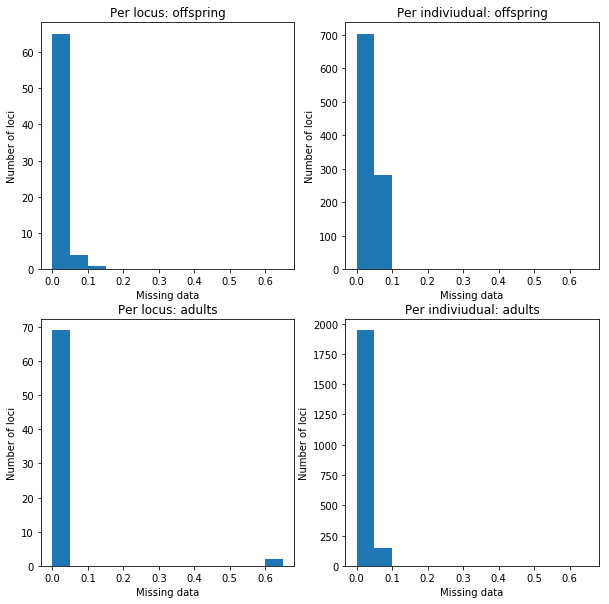

In [6]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.2, hspace=0.2)

mdo = fig.add_subplot(2,2,1)
mdo.hist(progeny.missing_data('marker'), bins=np.arange(0, 0.7, 0.05))
mdo.set_xlabel("Missing data")
mdo.set_ylabel("Number of loci")
mdo.set_title('Per locus: offspring')

indo = fig.add_subplot(2,2,2)
indo.hist(progeny.missing_data(by='individual'), bins=np.arange(0, 0.7, 0.05))
indo.set_xlabel("Missing data")
indo.set_ylabel("Number of loci")
indo.set_title('Per indiviudual: offspring')

mda = fig.add_subplot(2,2,3)
mda.hist(adults.missing_data('marker'), bins=np.arange(0, 0.7, 0.05))
mda.set_xlabel("Missing data")
mda.set_ylabel("Number of loci")
mda.set_title('Per locus: adults')

inda = fig.add_subplot(2,2,4)
inda.hist(adults.missing_data(by='individual'), bins=np.arange(0, 0.7, 0.05))
inda.set_xlabel("Missing data")
inda.set_ylabel("Number of loci")
inda.set_title('Per indiviudual: adults')
plt.show()

Remove the loci with dropouts >10% from both the offspring and adult datasets.

In [7]:
r = 0.1 # set maximum dropout rate
print progeny.markers[progeny.missing_data('marker') >= r]
print adults.markers[adults.missing_data('marker') >= r]

lx = (progeny.missing_data('marker') < r) * (adults.missing_data('marker') < r)
progeny = progeny.subset(loci=lx)
adults  = adults.subset(loci=lx)

['"s549_1270640"' '"s217_2722063"']
['"ros_assembly_18402"' '"ros_assembly_102102"']


## Heterozygosity

Allele frequency and heterozygosity generally show the convex pattern one would expect.

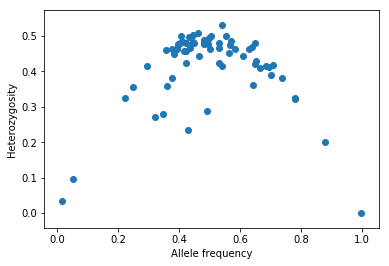

In [8]:
plt.scatter(adults.allele_freqs(), adults.heterozygosity(0))
plt.xlabel('Allele frequency')
plt.ylabel('Heterozygosity')
plt.show()

Loci with low heterozygosity are not dangerous in themselves; they might contribute some information, albeit little. To be on the safe side, let's remove loci with less than 0.15 heterozygosity, and the errant locus with high heterozygosity.

In [9]:
r = 0.15 # set minimum heterozygosity
print "Heterozygosity < 0.15:", progeny.markers[adults.heterozygosity('marker') < r]

progeny = progeny.subset(loci= (adults.heterozygosity('marker') > r))
adults  = adults.subset( loci= (adults.heterozygosity('marker') > r))

Heterozygosity < 0.15: ['"s154_504353"' '"s320_60828"' '"scpDNA_seq_58467"']


## Summary of genotype data

This leaves us with a dataset of 64 loci for which allele frequency and heterozygosity are highest around 0.5, which is what we would like. In particular, heterozygosity (and hence homozygosity) among the adults is humped around 0.5, which is a good sign that parents should be readily distinguishable. There is nevertheless substantial spread towards zero and one for the progeny data however, which is less than ideal.

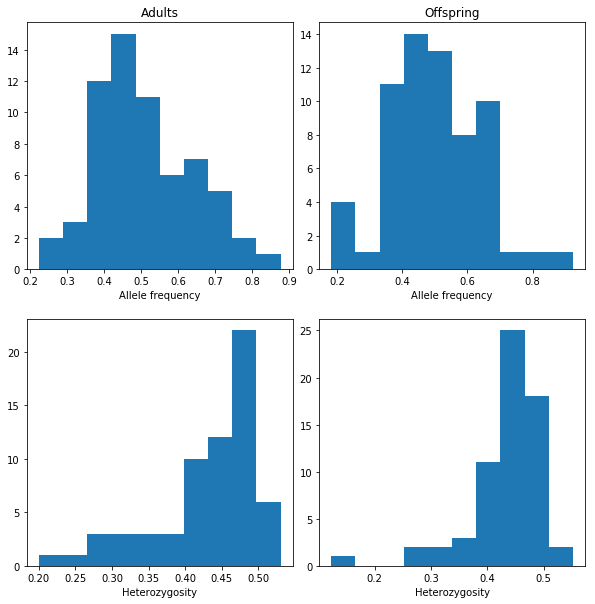

In [10]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.1, hspace=0.2)

afp = fig.add_subplot(2,2,1)
afp.hist(adults.allele_freqs())
afp.set_title('Adults')
afp.set_xlabel("Allele frequency")

afo = fig.add_subplot(2,2,2)
afo.hist(progeny.allele_freqs())
afo.set_title('Offspring')
afo.set_xlabel("Allele frequency")

hetp = fig.add_subplot(2,2,3)
hetp.hist(adults.heterozygosity(0))
hetp.set_xlabel("Heterozygosity")

heto = fig.add_subplot(2,2,4)
heto.hist(progeny.heterozygosity(0))
heto.set_xlabel("Heterozygosity")
plt.show()

The effective number of loci can be seen as the number of loci at which one can make compare the offspring, maternal and candidate paternal genotype (i.e. those loci with no missing data). Given how high dropouts are in the offspring, it is worthwhile to check the effective number of loci for this dataset.

In fact, effective number of loci is good. The minimum number of valid loci to compare is 46, and in 99% of cases there are 57 or more loci.

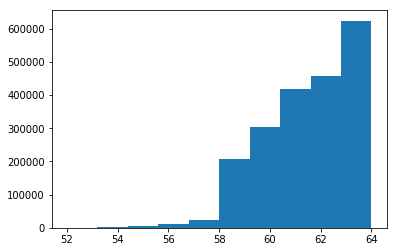

In [11]:
mothers = adults.subset(progeny.parent_index('m', adults.names))
neloci  = effective_nloci(progeny, mothers, adults)
plt.hist(neloci.flatten())
plt.show()

Finally, print some summary statistics about the quality of the genotype information in the data set.

In [12]:
print(adults.nloci)
print progeny.missing_data(0).mean()
print adults.missing_data(0).mean()
print adults.heterozygosity(0).min(), adults.heterozygosity(0).max()
print adults.allele_freqs().min(), adults.allele_freqs().max()

64
0.02618457825203252
0.007760217495219886
0.2002868068833652 0.5305927342256214
0.22401347449470646 0.8771718146718147
